Реализовать классификатор токсичных комментариев tfidf на базе датасета (если не успели на классном занятии) https://www.kaggle.com/datasets/blackmoon/russian-language-toxic-comments

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy as sp
import string
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

import nltk
import scikitplot as skplt
import re, string
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
STOPWORDS = set(stopwords.words('russian'))
#list of special characters.You can use regular expressions too

# importing the PorterStemmer
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize,word_tokenize
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
#importing the CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import SnowballStemmer
from pymorphy2 import MorphAnalyzer

# start text processing with vectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\150ho\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\150ho\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\150ho\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
ps = SnowballStemmer(language="russian")
lemmatizer = MorphAnalyzer()

In [3]:
dataset=pd.read_csv('labeled.csv')
dataset

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0
...,...,...
14407,Вонючий совковый скот прибежал и ноет. А вот и...,1.0
14408,А кого любить? Гоблина тупорылого что-ли? Или ...,1.0
14409,"Посмотрел Утомленных солнцем 2. И оказалось, ч...",0.0
14410,КРЫМОТРЕД НАРУШАЕТ ПРАВИЛА РАЗДЕЛА Т.К В НЕМ Н...,1.0


In [4]:
data = dataset.copy()

In [5]:
data = dataset.rename({'toxic':'Class','comment':'Message'},axis=1)

In [28]:
data

,Message,Class
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0
...,...,...
14407,Вонючий совковый скот прибежал и ноет. А вот и...,1.0
14408,А кого любить? Гоблина тупорылого что-ли? Или ...,1.0
14409,"Посмотрел Утомленных солнцем 2. И оказалось, ч...",0.0
14410,КРЫМОТРЕД НАРУШАЕТ ПРАВИЛА РАЗДЕЛА Т.К В НЕМ Н...,1.0


In [6]:
%%time
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]+|[\d]+', r'',text).strip()
    regex = re.compile('[%s]' % re.escape(string.punctuation))
    text = regex.sub(' ', text)
#     text = re.sub(r'[^0-9a-zA-Z]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = " ".join(word for word in text.split() if word not in STOPWORDS)
    text = " ".join(ps.stem(lemmatizer.normal_forms(word)[0]) for word in text.split())
    return text
  
data['clean_text'] = data['Message'].apply(clean_text)
data.head()

CPU times: total: 1min 47s
Wall time: 1min 49s


,Message,Class,clean_text
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0,верблюдовт деб бл
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0,хохол эт отдушин затюкан россиянин мол вон хох...
2,Собаке - собачья смерть\n,1.0,собак собач смерт
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0,страниц обнов деб эт оскорблен доказа факт нед...
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0,убед страничн пдф скрипал отрав росс анализиро...


In [7]:
X = data['clean_text']
y = data['Class']

In [8]:
#define a function to get rid of stopwords present in the messages
def message_text_process(mess):
    # Check characters to see if there are punctuations 
    no_punctuation=[char for char in mess if char not in string.punctuation]
    # now form the sentence
    no_punctuation=''.join(no_punctuation)
    # Now eliminate any stopwords
    return[word for word in no_punctuation.split() if word.lower() not in stopwords.words('english') and stopwords.words('russian')]

# to verify that function is working
data['Message'].head(5).apply(message_text_process)

0                   [Верблюдовто, за, что, Дебилы, бл]
1    [Хохлы, это, отдушина, затюканого, россиянина,...
2                            [Собаке, собачья, смерть]
3    [Страницу, обнови, дебил, Это, тоже, не, оскор...
4    [тебя, не, убедил, 6страничный, пдф, в, том, ч...
Name: Message, dtype: object

In [10]:
#function for the model building and prediction
def Model(model, X, y):
#training and testing the data
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=30)
    # model building using CountVectorizer and TfidfTransformer
    pipeline_model = Pipeline([('vect', CountVectorizer(ngram_range = (1,3))),
                              ('tfidf', TfidfTransformer()),
                              ('clf', model)])
    pipeline_model.fit(x_train, y_train)
    
    


    y_pred = pipeline_model.predict(x_test)
    y_probas =pipeline_model.predict_proba(x_test)
    skplt.metrics.plot_roc(y_test,y_probas,figsize=(12,8),title_fontsize=12,text_fontsize=16)
    plt.show()
    skplt.metrics.plot_precision_recall(y_test,y_probas,figsize=(12,8),title_fontsize=12,text_fontsize=16)
    plt.show()
    print("Confusion Matrix:\n",confusion_matrix(y_test,y_pred))
    print("Classification Report is:\n",classification_report(y_test, y_pred))
    print('Accuracy:', pipeline_model.score(x_test, y_test)*100)
    print("Training Score:\n",pipeline_model.score(x_train,y_train)*100)


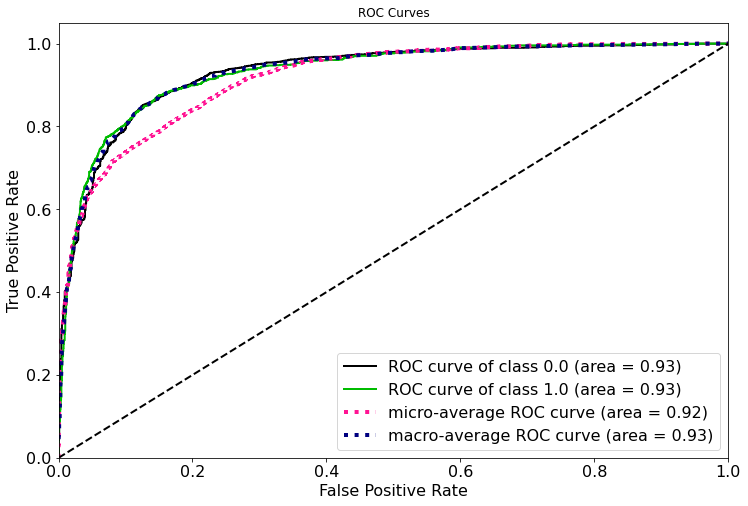

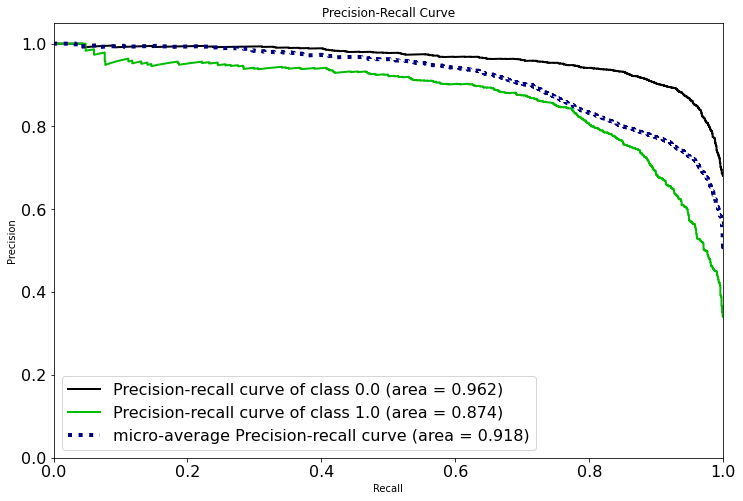

Confusion Matrix:
 [[2364   48]
 [ 599  592]]
Classification Report is:
               precision    recall  f1-score   support

         0.0       0.80      0.98      0.88      2412
         1.0       0.93      0.50      0.65      1191

    accuracy                           0.82      3603
   macro avg       0.86      0.74      0.76      3603
weighted avg       0.84      0.82      0.80      3603

Accuracy: 82.04274215931169
Training Score:
 90.84096586178185
CPU times: total: 13.1 s
Wall time: 6.36 s


In [11]:
%%time
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
Model(model, X, y)

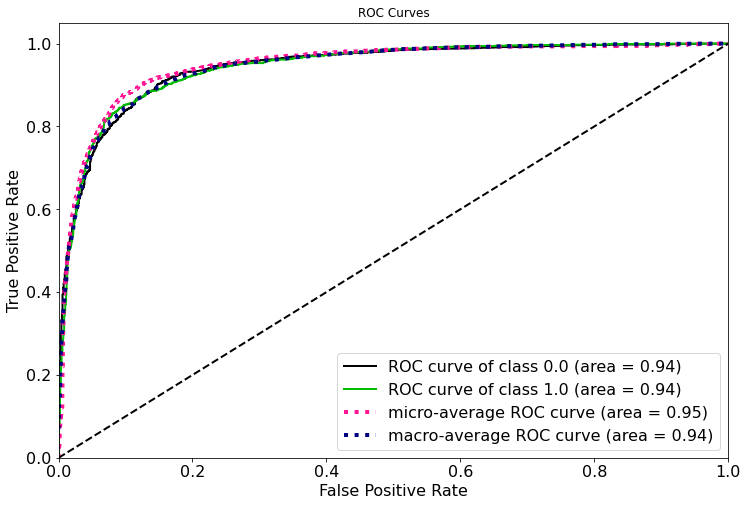

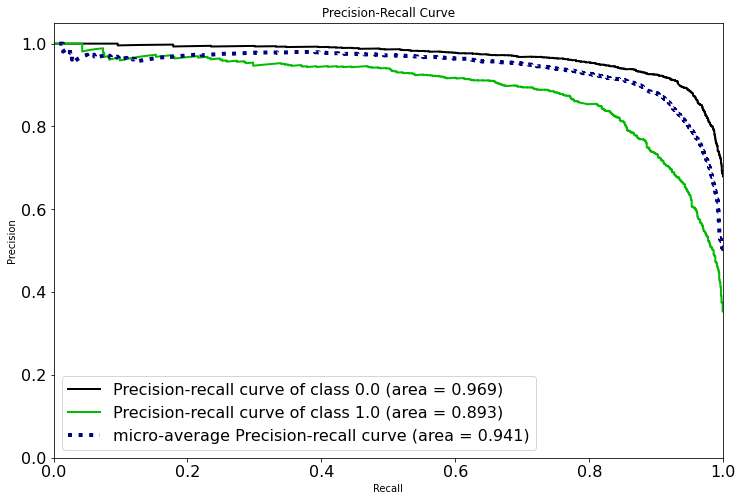

Confusion Matrix:
 [[2305  107]
 [ 331  860]]
Classification Report is:
               precision    recall  f1-score   support

         0.0       0.87      0.96      0.91      2412
         1.0       0.89      0.72      0.80      1191

    accuracy                           0.88      3603
   macro avg       0.88      0.84      0.86      3603
weighted avg       0.88      0.88      0.87      3603

Accuracy: 87.84346378018319
Training Score:
 99.47266167082986
CPU times: total: 4min 43s
Wall time: 4min 44s


In [14]:
%%time
from sklearn.svm import SVC
model = SVC(kernel='linear',probability=True)
Model(model, X, y)

In [12]:
#function for the model building and prediction
def Model1(model, X, y):
#training and testing the data
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=30)
    # model building using CountVectorizer and TfidfTransformer
    pipeline_model = Pipeline([('vect', CountVectorizer(ngram_range = (1,3))),
                              ('tfidf', TfidfTransformer()),
                              ('clf', model)])
    pipeline_model.fit(x_train, y_train)
    
    


    y_pred = pipeline_model.predict(x_test)
    print("Confusion Matrix:\n",confusion_matrix(y_test,y_pred))
    print("Classification Report is:\n",classification_report(y_test, y_pred))
    print('Accuracy:', pipeline_model.score(x_test, y_test)*100)
    print("Training Score:\n",pipeline_model.score(x_train,y_train)*100)


In [13]:
%%time
from sklearn.svm import LinearSVC
model = LinearSVC()
Model1(model, X, y)

Confusion Matrix:
 [[2304  108]
 [ 341  850]]
Classification Report is:
               precision    recall  f1-score   support

         0.0       0.87      0.96      0.91      2412
         1.0       0.89      0.71      0.79      1191

    accuracy                           0.88      3603
   macro avg       0.88      0.83      0.85      3603
weighted avg       0.88      0.88      0.87      3603

Accuracy: 87.53816264224258
Training Score:
 99.72245351096308
CPU times: total: 3.17 s
Wall time: 3.17 s
